In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
data = pd.read_csv('/content/Sentiment_Analysis_Dataset.csv', encoding='ISO-8859-1')

In [4]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stopwords.words('english')]
    return ' '.join(tokens)

In [5]:
data['cleaned_text'] = data['text'].apply(preprocess_text)

X = data['cleaned_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.3f}")

Cross-Validation Accuracy Scores: [0.72680412 0.67905057 0.65634675 0.66460268 0.66769866]
Mean Cross-Validation Accuracy: 0.679


In [6]:
param_grid = {
    'tfidfvectorizer__max_features': [1000, 5000, 10000, 20000],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'logisticregression__C': [0.1, 1, 10, 100]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'logisticregression__C': 10, 'tfidfvectorizer__max_features': 20000, 'tfidfvectorizer__ngram_range': (1, 2)}


In [7]:
y_pred = best_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7577319587628866
              precision    recall  f1-score   support

    negative       0.77      0.52      0.62       110
     neutral       0.77      0.89      0.83       571
    positive       0.72      0.58      0.65       289

    accuracy                           0.76       970
   macro avg       0.75      0.66      0.70       970
weighted avg       0.75      0.76      0.75       970



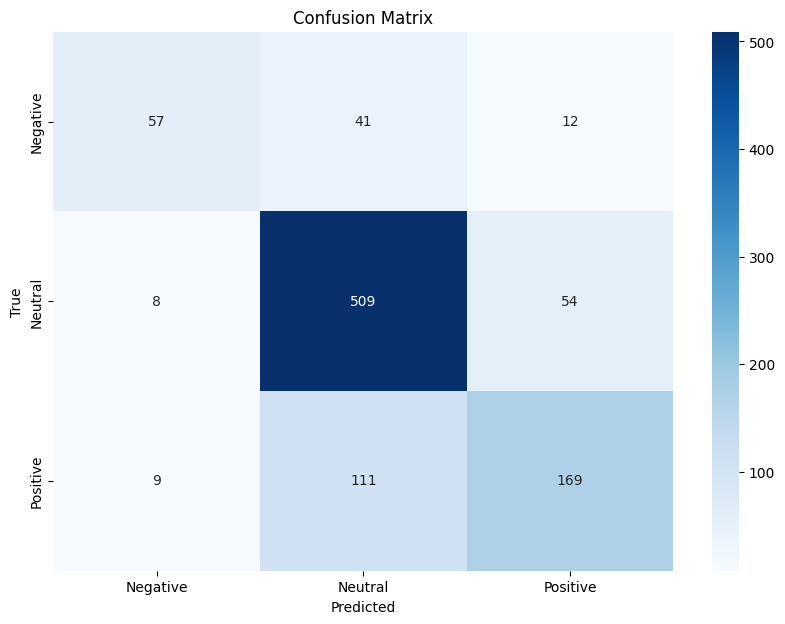

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-9-b9272db4cc9d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


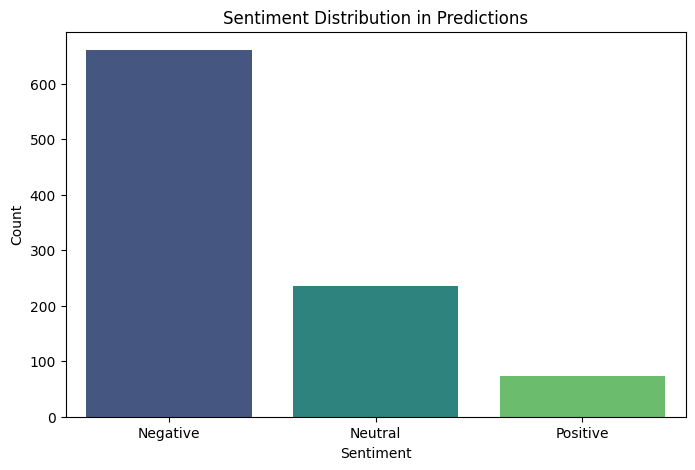

In [9]:
sentiment_counts = pd.Series(y_pred).value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Predictions')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

In [10]:
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(best_pipeline, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(best_pipeline.named_steps['tfidfvectorizer'], file)

In [13]:
# User Interface for Input Handling
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    prediction = best_pipeline.predict([processed_text])
    print(f"Model Prediction: {prediction}")  # Debugging line
    return prediction[0]  # Adjust this depending on the type of label (string or numeric)


# Example usage
user_input = input("Enter a sentence for sentiment analysis: ")
print("Predicted Sentiment:", predict_sentiment(user_input))

Enter a sentence for sentiment analysis: i was feeling good
Model Prediction: ['positive']
Predicted Sentiment: positive
